In [1]:
import time
import copy
import torch
from torch import optim, nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.models import resnet18
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import sys
sys.path.append("..")
from IPython import display
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore") # 忽略警告

In [2]:
def read_voc_images(root="../../data/VOCdevkit/VOC2012", is_train=True, max_num=None):
    txt_fname = '%s/ImageSets/Segmentation/%s' % (root, 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split() # 拆分成一个个名字组成list
    if max_num is not None:
        images = images[:min(max_num, len(images))]
    features, labels = [None] * len(images), [None] * len(images)
    for i, fname in tqdm(enumerate(images)):
        # 读入数据并且转为RGB的 PIL image
        features[i] = Image.open('%s/JPEGImages/%s.jpg' % (root, fname)).convert("RGB")
        labels[i] = Image.open('%s/SegmentationClass/%s.png' % (root, fname)).convert("RGB")
    return features, labels # PIL image 0-255

In [3]:
def set_figsize(figsize=(3.5, 2.5)):
    """在jupyter使用svg显示"""
    display.set_matplotlib_formats('svg')
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

def show_images(imgs, num_rows, num_cols, scale=2):
    # a_img = np.asarray(imgs)
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    plt.show()
    return axes

10it [00:00, 127.45it/s]


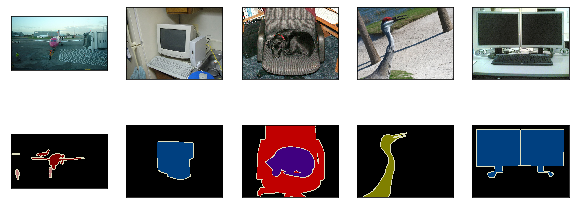

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EA605EE648>,
      dtype=object)

In [4]:
# 数据集的路径
voc_dir = r"./data/VOCdevkit/VOC2012"
train_features, train_labels = read_voc_images(voc_dir, max_num=10)
n = 5 # 展示几张图像
imgs = train_features[0:n] + train_labels[0:n] # PIL image
show_images(imgs, 2, n)

In [5]:
# 标签中每个RGB颜色的值
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
# 标签其标注的类别
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [6]:
colormap2label = torch.zeros(256**3, dtype=torch.uint8) # torch.Size([16777216])
for i, colormap in enumerate(VOC_COLORMAP):
    # 每个通道的进制是256，这样可以保证每个 rgb 对应一个下标 i
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

# 构造标签矩阵
def voc_label_indices(colormap, colormap2label):
    colormap = np.array(colormap.convert("RGB")).astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2]) 
    return colormap2label[idx] # colormap 映射 到colormaplabel中计算的下标


In [7]:
y = voc_label_indices(train_labels[0], colormap2label)
print(y[100:110, 130:140]) #打印结果是一个int型tensor，tensor中的每个元素i表示该像素的类别是VOC_CLASSES[i]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]], dtype=torch.uint8)


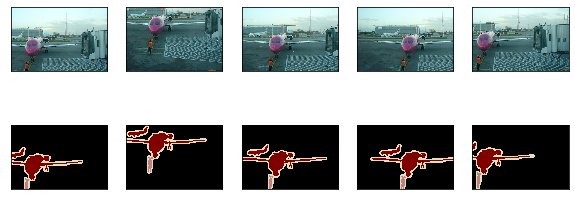

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EA6195A088>,
      dtype=object)

In [8]:
def voc_rand_crop(feature, label, height, width):
    """
    随机裁剪feature(PIL image) 和 label(PIL image).
    为了使裁剪的区域相同，不能直接使用RandomCrop，而要像下面这样做
    Get parameters for ``crop`` for a random crop.
    Args:
        img (PIL Image): Image to be cropped.
        output_size (tuple): Expected output size of the crop.
    Returns:
        tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
    """
    i,j,h,w = torchvision.transforms.RandomCrop.get_params(feature, output_size=(height, width))
    feature = torchvision.transforms.functional.crop(feature, i, j, h, w)
    label = torchvision.transforms.functional.crop(label, i, j, h, w)
    return feature, label

# 显示n张随机裁剪的图像和标签，前面的n是5
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
show_images(imgs[::2] + imgs[1::2], 2, n)


In [9]:
class VOCSegDataset(torch.utils.data.Dataset):
    def __init__(self, is_train, crop_size, voc_dir, colormap2label, max_num=None):
        """
        crop_size: (h, w)
        """
        # 对输入图像的RGB三个通道的值分别做标准化
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        self.tsf = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=self.rgb_mean, std=self.rgb_std)])
        self.crop_size = crop_size # (h, w)
        features, labels = read_voc_images(root=voc_dir, is_train=is_train,  max_num=max_num)
# 由于数据集中有些图像的尺寸可能小于随机裁剪所指定的输出尺寸，这些样本需要通过自定义的filter函数所移除
        self.features = self.filter(features) # PIL image
        self.labels = self.filter(labels)     # PIL image
        self.colormap2label = colormap2label
        print('read ' + str(len(self.features)) + ' valid examples')

    def filter(self, imgs):
        return [img for img in imgs if (
            img.size[1] >= self.crop_size[0] and img.size[0] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx], *self.crop_size)
                                # float32 tensor           uint8 tensor (b,h,w)
        return (self.tsf(feature), voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)


In [10]:
batch_size = 10 
crop_size = (320, 480) # 指定随机裁剪的输出图像的形状为(320,480)
max_num = 20000 # 图片最大数量

# 创建训练集和测试集的实例
voc_train = VOCSegDataset(True, crop_size, voc_dir, colormap2label, max_num)
voc_test = VOCSegDataset(False, crop_size, voc_dir, colormap2label, max_num)

# 设批量大小为10，分别定义【训练集】和【测试集】的数据迭代器
num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                              drop_last=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(voc_test, batch_size, drop_last=True,
                             num_workers=num_workers)

# 方便封装，把训练集和验证集保存在dict里
dataloaders = {'train':train_iter, 'val':test_iter}
dataset_sizes = {'train':len(voc_train), 'val':len(voc_test)}

1464it [00:06, 218.17it/s]
25it [00:00, 240.97it/s]read 1114 valid examples
1449it [00:06, 210.70it/s]read 1078 valid examples



In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 21 # 21分类，1个背景，20个物体
model_ft = resnet18(pretrained=True) # 加载使用训练好的参数

# 特征提取器
for param in model_ft.parameters():
    param.requires_grad = False

In [12]:
model_ft = nn.Sequential(*list(model_ft.children())[:-2], # 去掉最后两层
              nn.Conv2d(512,num_classes,kernel_size=1), # 用大小为1的卷积层改变输出通道为num_class
              nn.ConvTranspose2d(num_classes,num_classes, kernel_size=64, padding=16, stride=32)).to(device) # 转置卷积层使图像变为输入图像的大小

In [13]:
# 双线性插值的上采样，用来初始化转置卷积层的卷积核
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size+1)//2
    if kernel_size%2 == 1:
        center = factor-1
    else:
        center = factor-0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1-abs(og[0]-center)/factor) * (1-abs(og[1]-center)/factor)
    weight = np.zeros((in_channels,out_channels, kernel_size,kernel_size), dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    weight = torch.Tensor(weight)
    weight.requires_grad = True
    return weight

In [14]:
nn.init.xavier_normal_(model_ft[-2].weight.data, gain=1)
model_ft[-1].weight.data = bilinear_kernel(num_classes, num_classes, 64).to(device)

In [15]:
log_writer = SummaryWriter()
def train_model(model: nn.Module, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # 每个epoch都有一个训练和验证阶段
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            runing_loss = 0.0
            runing_corrects = 0.0
            # 迭代一个epoch
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()  # 零参数梯度
                # 前向，只在训练时跟踪参数
                with torch.set_grad_enabled(phase == 'train'):
                    logits = model(inputs)  # [5, 21, 320, 480]
                    loss = criteon(logits, labels.long())
                    # 后向，只在训练阶段进行优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        # 统计loss和correct
                runing_loss += loss.item()*inputs.size(0)
                runing_corrects += torch.true_divide(
                    torch.sum((torch.argmax(logits.data, 1)) == labels.data), (480*320))

            epoch_loss = runing_loss / dataset_sizes[phase]
            epoch_acc = runing_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
                log_writer.add_scalar('train_loss', float(epoch_loss), epoch)
            else:
                log_writer.add_scalar('val_acc', float(epoch_acc), epoch)    
            # 深度复制model参数
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    log_writer.close()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed//60, time_elapsed % 60))
    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

In [16]:
epochs = 30 # 训练30个epochs
criteon = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
# 设置learning rate衰减因子为0.3，每3个epochs衰减一次
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)

# 开始训练
model_ft = train_model(model_ft, criteon, optimizer, exp_lr_scheduler, num_epochs=epochs)

Epoch 0/29
----------
train Loss: 4.8987 Acc: 0.7035
val Loss: 2.2776 Acc: 0.7761

Epoch 1/29
----------
train Loss: 1.9252 Acc: 0.7684
val Loss: 1.9641 Acc: 0.7750

Epoch 2/29
----------
train Loss: 1.1332 Acc: 0.8002
val Loss: 1.0968 Acc: 0.8041

Epoch 3/29
----------
train Loss: 0.8682 Acc: 0.8143
val Loss: 1.0798 Acc: 0.7833

Epoch 4/29
----------
train Loss: 0.8117 Acc: 0.8147
val Loss: 0.8705 Acc: 0.8074

Epoch 5/29
----------
train Loss: 0.6534 Acc: 0.8323
val Loss: 0.8051 Acc: 0.8149

Epoch 6/29
----------
train Loss: 0.6290 Acc: 0.8329
val Loss: 0.8081 Acc: 0.8033

Epoch 7/29
----------
train Loss: 0.6233 Acc: 0.8316
val Loss: 0.7809 Acc: 0.8042

Epoch 8/29
----------
train Loss: 0.5803 Acc: 0.8370
val Loss: 0.7618 Acc: 0.8110

Epoch 9/29
----------
train Loss: 0.5727 Acc: 0.8385
val Loss: 0.7459 Acc: 0.8116

Epoch 10/29
----------
train Loss: 0.5753 Acc: 0.8379
val Loss: 0.7505 Acc: 0.8097

Epoch 11/29
----------
train Loss: 0.5717 Acc: 0.8376
val Loss: 0.7459 Acc: 0.8091

Ep

In [17]:
torch.save(model_ft,'FCN.pth') # 保存模型

In [18]:
def label2image(pred):
    # pred: [320,480]
    colormap = torch.tensor(VOC_COLORMAP,device=device,dtype=int)
    x = pred.long()
    return (colormap[x,:]).data.cpu().numpy()

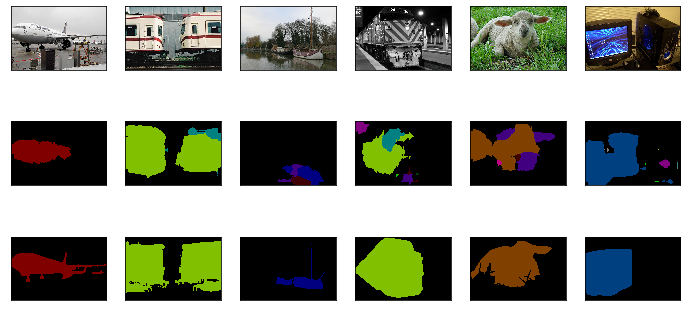

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [19]:
mean=torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1).to(device)
std=torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1).to(device)
def visualize_model(model:nn.Module, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    n, imgs = num_images, []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs, labels = inputs.to(device), labels.to(device) # [b,3,320,480]
            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=1) # [b,320,480]
            inputs_nd = (inputs*std+mean).permute(0,2,3,1)*255

            for j in range(num_images):
                images_so_far += 1
                pred1 = label2image(pred[j]) # numpy.ndarray (320, 480, 3)
                imgs += [inputs_nd[j].data.int().cpu().numpy(), pred1, label2image(labels[j])]
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n)
                    return model.train(mode=was_training)

# 开始验证
visualize_model(model_ft)